In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
from collections import Counter
import keras 


C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 1. Word vectorizer

In [2]:
# corpus = pd.read_table('data.txt')[:1000]
# corpus = [i.split() for i in corpus['10768'].values]
# bag = [[0 for _ in range(len(i))] for i in corpus]
# word_dict = {}
# i = 0
# for doc_num in range(len(corpus)):
#     for word_index in range(len(corpus[doc_num])):
#         word = corpus[doc_num][word_index]
#         if word in word_dict:
#             bag[doc_num][word_index] = word_dict[word]
#         else:            
#             word_dict[word] = i
#             bag[doc_num][word_index] = word_dict[word]
#             i+=1
       

In [3]:
data = np.load('lda.npz')
data_train = data['train']
data_test = data['test']
data_train[:,0] = data_train[:,0]-1
data_test[:,0] = data_test[:,0]-1
# def preprocess(data_train):
#     text = [[] for _ in range(max(data_train[:,0])+1)]
#     for doc in data_train:
#         doc_index = doc[0]
#         word_index = doc[1]
#         num = doc[2]
#         while num>0:
#             text[doc_index].append(word_index)
#             num-=1
#     return text
# bag = preprocess(data_train)

In [4]:
res = []
for vec in data_train:
    if vec[-1] ==1:
        res.append(vec)
    else:
        new_vec = vec.copy()
        new_vec[-1]=1
        for _ in range(vec[-1]):
            res.append(new_vec)
            

In [6]:
np.save('lda_processed',res)


## 1.Initialization

*  Cluster number  $k$
* hyperparameter for two dirichlet conjugate $\alpha,\beta$
* The number of unique word **top_words_num**
* The number of document $n$
* nw 词在各topic的数量
* nwsum 每个topic词的总数
* nd 每个doc中topic的总数
* ndsum 每个doc中词的总数


In [7]:
k = 10
alpha = 1
beta = 1
top_words_num = max(data_train[:,1])+1
n = len(bag)

nw = np.zeros((top_words_num,k))
nwsum = np.zeros(k)
nd = np.zeros((n,k))

ndsum = np.zeros(n)

z = [[[0] for _ in range(len(l))] for l in bag] #topic for evary word in doc

for i in range(n):
    ndsum[i] = len(bag[i])
    for j in range(len(bag[i])):
        topic = np.random.randint(k)
        z[i][j] = topic
        nw[bag[i][j]][topic]+=1 
        nd[i][topic]+=1
        nwsum[topic]+=1
p = []

In [149]:
#超参数
k = 10
alpha = 1
beta = 1
top_words_num = max(data_train[:,1])+1
n = len(bag)

#变成word_num都是1
res = []
for vec in data_train:
    if vec[-1] ==1:
        res.append(vec)
    else:
        new_vec = vec.copy()
        new_vec[-1]=1
        for _ in range(vec[-1]):
            res.append(new_vec)

#初始化
doc_word_sum = np.zeros(n)
topic_word_sum = np.zeros(k)
doc_topic_count = np.zeros((n,k))
word_topic_count = np.zeros((top_words_num,k))
topic_att = []
for doc_idx,word_idx,word_num in res:
    topic = np.random.randint(0,k,1)[0] #随机初始化主题
    topic_att.append(topic)
    
    doc_word_sum[doc_idx]+=word_num #文档数量加上单词数量
    topic_word_sum[topic]+=word_num 
    
    doc_topic_count[doc_idx,topic]+=word_num
    word_topic_count[word_idx,topic]+=word_num
    
    

In [151]:
#更新z
loss_l = []
for it in range(1,20):
    start = time.time()
    nt = []
    print('第{}轮训练开始'.format(it))
    for ((doc_idx,word_idx,word_num),topic) in zip(res,topic_att):
            

        doc_topic_count[doc_idx,topic]-=1 #词在各topic的数量
        word_topic_count[word_idx,topic]-=1 #每个doc中topic的总数
        doc_word_sum[doc_idx]-=1 #nwsum 每个topic词的总数
        topic_word_sum[topic]-=1 #每个doc中词的总数

        topic_doc =  (doc_topic_count[doc_idx]+alpha)/(doc_word_sum[doc_idx] + k*alpha) #
        word_topic = (word_topic_count[word_idx]+beta)/(topic_word_sum+ top_words_num*beta )
        prob = topic_doc*word_topic
        prob = prob/sum(prob)

        new_topic = np.random.multinomial(1,prob,size=1)[0].argmax()

        doc_topic_count[doc_idx,new_topic]+=1 #词在各topic的数量
        word_topic_count[word_idx,new_topic]+=1 #每个doc中topic的总数
        doc_word_sum[doc_idx]+=1 #nwsum 每个topic词的总数
        topic_word_sum[new_topic]+=1 #每个doc中词的总数
        
        nt.append(new_topic)
        
    topic_att = nt
    print('开始计算complexity')
    error_sum = 0
    doc_pb = (doc_topic_count + alpha) / (doc_word_sum + k*alpha).reshape(-1,1)[0]
    word_pb = (word_topic_count + beta) / (topic_word_sum +top_words_num*beta)
    for doc_idx,word_idx,word_num in res:
        error_sum+=np.log(np.sum(doc_pb[doc_idx] * word_pb[word_idx]))
    loss = np.exp(-error_sum/len(res))
    duration =time.time() - start
    loss_l.append(loss)
    print ("第{}轮训练结束,loss:{},耗时:{}".format(it,loss,duration))
        
 
         

第1轮训练开始
开始计算complexity
第1轮训练结束,loss:3206.276425718486,耗时:74.53458523750305
第2轮训练开始
开始计算complexity
第2轮训练结束,loss:3187.2323658212913,耗时:79.67385578155518
第3轮训练开始
开始计算complexity
第3轮训练结束,loss:3153.7885798732623,耗时:75.42496681213379
第4轮训练开始
开始计算complexity
第4轮训练结束,loss:3097.1885274535966,耗时:74.39279699325562
第5轮训练开始
开始计算complexity
第5轮训练结束,loss:3001.549374157444,耗时:76.55268359184265
第6轮训练开始
开始计算complexity
第6轮训练结束,loss:2862.980887718221,耗时:82.87169146537781
第7轮训练开始
开始计算complexity
第7轮训练结束,loss:2715.261048307174,耗时:75.9297845363617
第8轮训练开始
开始计算complexity
第8轮训练结束,loss:2597.775292457261,耗时:76.46392965316772
第9轮训练开始
开始计算complexity
第9轮训练结束,loss:2515.167382424756,耗时:71.53588485717773
第10轮训练开始
开始计算complexity
第10轮训练结束,loss:2457.092866664009,耗时:73.98675537109375
第11轮训练开始
开始计算complexity
第11轮训练结束,loss:2414.1583020288767,耗时:68.99713659286499
第12轮训练开始
开始计算complexity
第12轮训练结束,loss:2381.978481451858,耗时:71.11856317520142
第13轮训练开始
开始计算complexity
第13轮训练结束,loss:2356.68878815219,耗时:68.8812665939331
第14轮训练开始
开始计算com

In [92]:
# #更新z
# for it in range(10):
#     for doc_index in range(n):
#         for word_index in range(len(z[doc_index])):
            
#             topic = z[doc_index][word_index] #取出该位置原来的topic
#             word = bag[doc_index][word_index] # 该位置的word
            
#             nw[word][topic]-=1 #词在各topic的数量
#             nd[doc_index][topic]-=1 #每个doc中topic的总数
#             nwsum[topic]-=1 #nwsum 每个topic词的总数
#             ndsum[doc_index]-=1 #每个doc中词的总数

#             topic_doc =  (nd[doc_index]+alpha)/(ndsum[doc_index] + k*alpha) #
#             word_topic = (nw[word]+beta)/(nwsum + top_words_num*beta )
#             prob = topic_doc*word_topic

#             prob = prob/sum(prob)
            
#             new_topic = np.random.multinomial(1,prob,size=1)[0].argmax()

#             nw[word][new_topic]+=1
#             nd[doc_index][new_topic]+=1
#             nwsum[new_topic]+=1
#             ndsum[doc_index]+=1
            
#             z[doc_index][word_index] = new_topic #更新topic
         
#     theta_res = (nd + alpha)/(ndsum.reshape(-1,1)+k*alpha) #probability of each document
#     phi_res = (nw.T + beta) / (nwsum.reshape(-1,1)+top_words_num*beta) #probability of each word given topic
#     likelihood = [np.sum(theta_res[a] * phi_res[:,b]) ** c for a,b,c in data_test]
#     df = pd.DataFrame(data = likelihood,columns=['likelihood'])
#     df['label'] = data_test[:,0]
#     df['log'] = np.log(df['likelihood'])
#     loss = np.sum(df.groupby('label')['log'].sum())
#     loss = np.exp(-loss/len(data_test))
#     p.append(loss)
#     print (loss)

7794466.944968274
7379401.164005599


KeyboardInterrupt: 

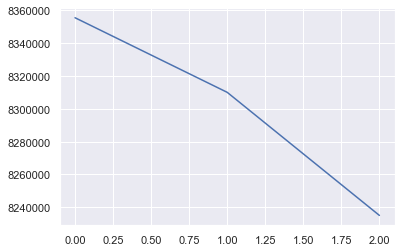

In [51]:
sns.set()
plt.plot(p)
plt.show()

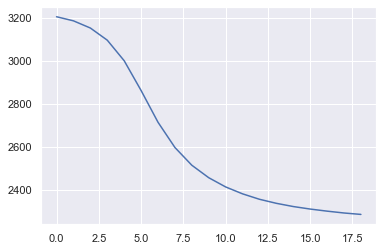

In [155]:
plt.plot(loss_l)

In [ ]:
import scipy.io as scio
 
dataFile = '..//data.mat'
data = scio.loadmat(dataFile)

In [2]:
import os
os.chdir('DirBN-master/data')

In [5]:
import scipy.io as scio
from scipy.sparse import csc_matrix
from scipy import sparse
import numpy as np
dataFile = 'TMN.mat'
data = scio.loadmat(dataFile)

In [10]:
dat = data['x'].toarray()
a,b = np.where(dat>0)
kk = np.zeros((len(a),3),dtype='int')
kk[:,0] = a
kk[:,1] = b    
dd = []
for (word_idx,doc_idx) in zip(a,b):
    dd.append(dat[word_idx,doc_idx])
kk[:,-1] = dd  

In [22]:
res = []
for vec in kk:
    if vec[-1] ==1:
        res.append(vec)
    else:
        new_vec = vec.copy()
        new_vec[-1]=1
        for _ in range(vec[-1]):
            res.append(new_vec)

array([[    0,     0,     1],
       [    0,     7,     2],
       [    0,     8,     2],
       ...,
       [13369, 28352,     1],
       [13369, 29157,     2],
       [13369, 31593,     2]])